In [1]:
import numpy as np
import pandas as pd
import statsmodels as sm
import matplotlib.pyplot as plt
import seaborn as sns
import pathlib
import requests

from bs4 import BeautifulSoup

In [2]:
%matplotlib inline

In [3]:
%load_ext autoreload
%autoreload 2

### Оглавление.

1. [Чтение и предобработка данных.](#readdata)
  * [Проверка данных на адекватность.](#datacheck)
  * [Графики.](#plots)
2. [Модель для индекса ИПЦ в целом.](#CPI)
3. [Модель для трёх субиндексов ИПЦ:](#3indexes) 
  * [Модель для продовольственных товаров.](#foods) 
  * [Модель для непродовольственных товаров.](#nonfoods)
  * [Модель для цен на услуги.](#services) 
4. [Агрегированная модель.](#aggmodel)

## 1 Чтение и предобработка данных. <a class="anchor" id="readdata"></a>

###  1.1 Проверка данных на адекватность. <a class="anchor" id="datacheck"></a>

In [4]:
# parser нельзя использовать как имя модуля - оно уже занято в дефолтном Питоне

%run gks_parser.py

# к сожалению, из-за косяков Chromedriver и Windows приходится запускать модуль
# импорт модуля и запуск класса не работает, увы

# from gks_parser import CPIparser
# Parser = CPIparser()
# скачаем данные с сайта Росстата
# Parser.get_gks_data()
# переформатируем их в человеческий вид
# Parser.preprocess()

D:\Macro\CPI\data\cpi.xlsx
Data for cpi already exists. Last changes at 2021-05-31.
Do you want to overwrite existing file? Yes/No: yes
Data for cpi is overwritten
D:\Macro\CPI\data\foods.xlsx
Data for foods already exists. Last changes at 2021-05-31.
Do you want to overwrite existing file? Yes/No: yes
Data for foods is overwritten
D:\Macro\CPI\data\nonfoods.xlsx
Data for nonfoods already exists. Last changes at 2021-05-31.
Do you want to overwrite existing file? Yes/No: yes
Data for nonfoods is overwritten
D:\Macro\CPI\data\services.xlsx
Data for services already exists. Last changes at 2021-05-31.
Do you want to overwrite existing file? Yes/No: yes
Data for services is overwritten
D:\Macro\CPI\data\weights.xlsx
Data for weights already exists. Last changes at 2021-05-31.
Do you want to overwrite existing file? Yes/No: yes
Data for weights is overwritten
Data for D:\Macro\CPI\data\cpi.xlsx is reformated
Data for D:\Macro\CPI\data\foods.xlsx is reformated
Data for D:\Macro\CPI\data\non

In [8]:
data = pd.read_csv('data/clean_data.csv', index_col=0, parse_dates=True)

In [9]:
data.head()

,cpi,foods,nonfoods,services,foods_weight,nonfoods_weight,services_weight
month,,,,,,,
1991-01-31,0.062,0.046,0.090,0.032,NaN,NaN,NaN
1991-02-28,0.048,0.031,0.059,0.052,NaN,NaN,NaN
1991-03-31,0.063,0.052,0.046,0.055,NaN,NaN,NaN
1991-04-30,0.635,0.718,0.705,0.215,NaN,NaN,NaN
1991-05-31,0.030,0.005,0.054,0.039,NaN,NaN,NaN


Итак, что мы видим: есть данные для агрегированного ИПЦ (приросты индекса цен месяц к месяцу), есть данные по трём субиндексам (проды, непроды, услуги). Проблема одна - нет весов для ряда лет.

Сначала проверим, что наши данные адекватные. 
1. Сверим ИПЦ, который даёт Росстат в агрегированном виде, и ИПЦ, рассчитанный как взвешенная сумма субиндексов.

In [67]:
print('Агрегированный индекс ИПЦ за 2020 год')
print('-------------------------------------')
data.cpi['2020']
print('-------------------------------------')
print('Расчёт ИПЦ по субиндексам за 2020 год')
print('-------------------------------------')
(data.foods * data.foods_weight + data.nonfoods * data.nonfoods_weight + data.services * data.services_weight)['2020']

Агрегированный индекс ИПЦ за 2020 год
-------------------------------------


month
2020-01-31    0.0040
2020-02-29    0.0033
2020-03-31    0.0055
2020-04-30    0.0083
2020-05-31    0.0027
2020-06-30    0.0022
2020-07-31    0.0035
2020-08-31   -0.0004
2020-09-30   -0.0007
2020-10-31    0.0043
2020-11-30    0.0071
2020-12-31    0.0083
Name: cpi, dtype: float64

-------------------------------------
Расчёт ИПЦ по субиндексам за 2020 год
-------------------------------------


month
2020-01-31    0.004028
2020-02-29    0.003278
2020-03-31    0.005489
2020-04-30    0.008241
2020-05-31    0.002752
2020-06-30    0.002159
2020-07-31    0.003518
2020-08-31   -0.000374
2020-09-30   -0.000714
2020-10-31    0.004323
2020-11-30    0.007134
2020-12-31    0.008233
dtype: float64

2. Проверим, что годовая инфляция совпадает с официальной.

month
2016-12-31    0.053751
2017-12-31    0.025231
2018-12-31    0.042690
2019-12-31    0.030462
2020-12-31    0.049125
Name: cpi, dtype: float64


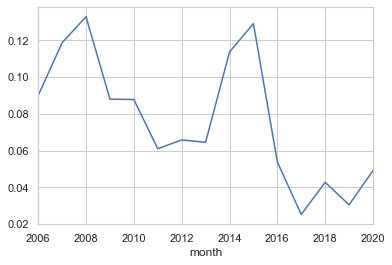

In [77]:
print(((data.dropna().cpi + 1).groupby(data.dropna().index.year).cumprod() -1).loc[data.dropna().index.month == 12].tail(5))
((data.dropna().cpi + 1).groupby(data.dropna().index.year).cumprod() -1).loc[data.dropna().index.month == 12].plot();

Да, всё совпадает.

### 1.2 Графики. <a class="anchor" id="plots"></a>

Нарисуем три субиндекса и сам ИПЦ вместе.

In [20]:
from matplotlib import rcParams

In [21]:
rcParams['font.size'] = 12

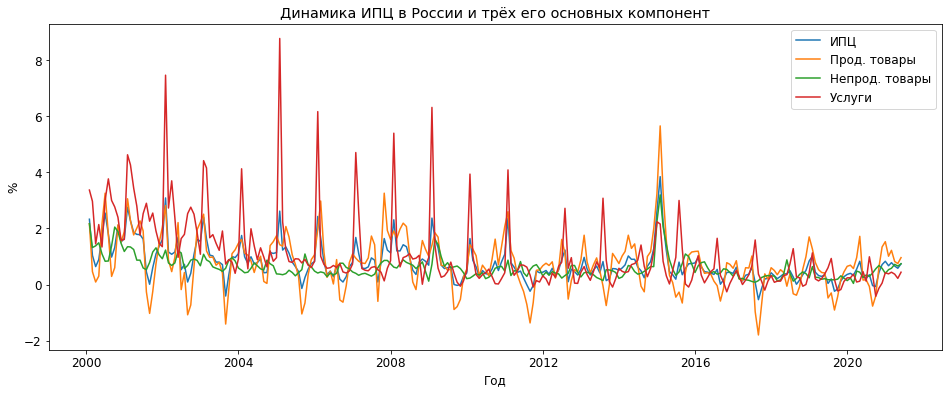

In [26]:
fig, ax = plt.subplots(figsize=(16, 6));

plot_data = data.loc['2000':, ['cpi', 'foods', 'nonfoods','services']]
ax.plot(plot_data.cpi*100, label='ИПЦ');
ax.plot(plot_data.foods*100, label='Прод. товары');
ax.plot(plot_data.nonfoods*100, label='Непрод. товары');
ax.plot(plot_data.services*100, label='Услуги');

ax.set_title('Динамика ИПЦ в России и трёх его основных компонент');
ax.set_xlabel('Год');
ax.set_ylabel('%');
ax.legend();

Можно сразу сделать несколько наблюдений:
1. Шок 2014 года привёл к изменению динамики всех субиндексов и индекса ИПЦ в целом. 
2. До 2014 года услуги показывали самые высокие значения роста цен, после 2014 самыми волатильными стали продовольственными товарами. 
3. Судя по всплескам 2009 и 2014 годов, можно предположить, что существует эффект переноса шоков валютного курса в первую очередь в продовольственные цены и в некоторой степени в цены непродовольственных товаров.
4. Совершенно очевидно наличие сезонности, её надо обязательно замоделировать.

Посмотрим отдельно на динамику самого ИПЦ:

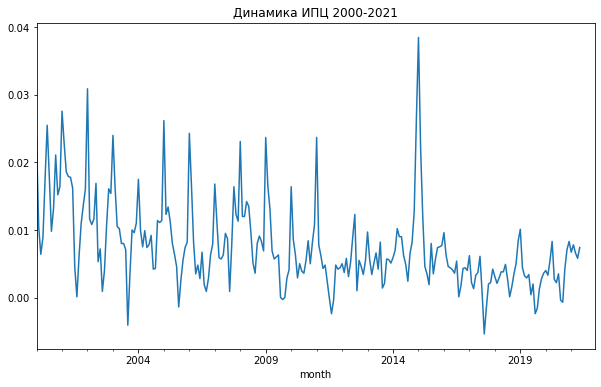

In [19]:
data['2000':].cpi.plot(label='CPI', title='Динамика ИПЦ 2000-2021', figsize=(10, 6));

И на динамику его весов:

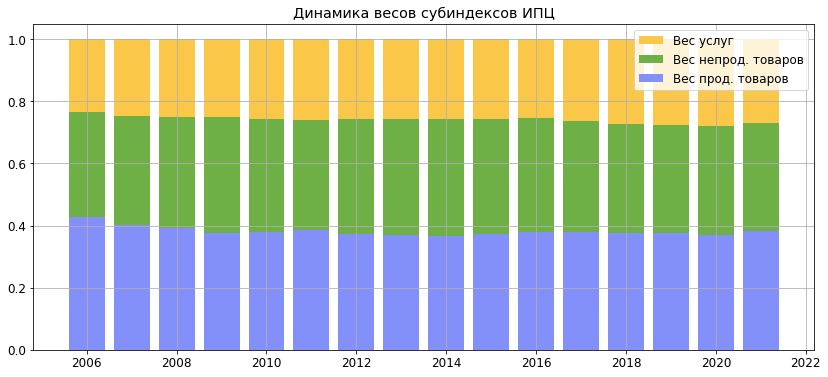

In [36]:
fig, ax = plt.subplots(figsize=(14, 6));

weight_data = data[['foods_weight', 'nonfoods_weight', 'services_weight']]
weight_data = weight_data.groupby(weight_data.index.year).agg('mean').dropna()

ax.bar(weight_data.index, 
       weight_data.nonfoods_weight+weight_data.foods_weight+weight_data.services_weight, 
       color='#FAC748', label='Вес услуг');
ax.bar(weight_data.index, 
       weight_data.nonfoods_weight+weight_data.foods_weight, 
       color='#6EAF46', label='Вес непрод. товаров');
ax.bar(weight_data.index, 
       weight_data.foods_weight, 
       color='#8390FA', label='Вес прод. товаров');

ax.legend(loc='best');
ax.set_title('Динамика весов субиндексов ИПЦ');
ax.grid(True);

Видно, что динамика весов стабильна, и у продовольствия всегда наибольший вес. С учётом того, что оно на текущий момент ещё и наиболее волатильно, ему следует уделить наибольшее внимание.

In [46]:
def seasonal_plot(ts, n_periods, plot_size, 
                  title, xlabel, ylabel):
    
    '''Seasonal chart for n_periods in year'''
    
    colors = plt.cm.viridis_r(np.linspace(0,1,ts.index.year.unique().shape[0]))
    
    plt.figure(figsize=plot_size)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    
    for i, year in enumerate(ts.index.year.unique().values.tolist()):
        plt.plot(list(range(1, n_periods+1)), 
                 ts[str(year)].values, 
                 label=str(year), 
                 color=colors[i])
    plt.legend(bbox_to_anchor=(1.05, 1)); 

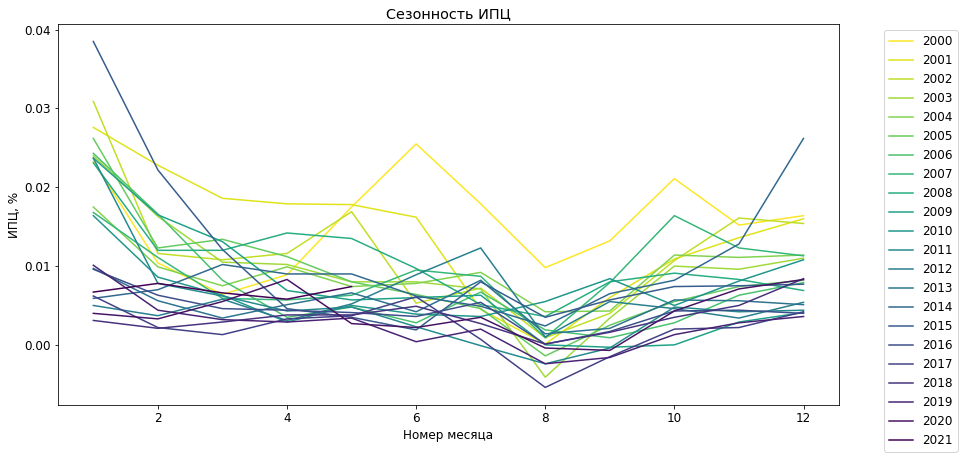

In [50]:
seasonal_plot(ts=data.cpi['2000':], plot_size=(14, 7), n_periods=12,
              title='Сезонность ИПЦ', ylabel='ИПЦ, %', xlabel='Номер месяца')

Понятно, что у каждого из рядов субиндексов свой характер сезонности. Наиболее выраженная наверняка у продовольственных товаров:

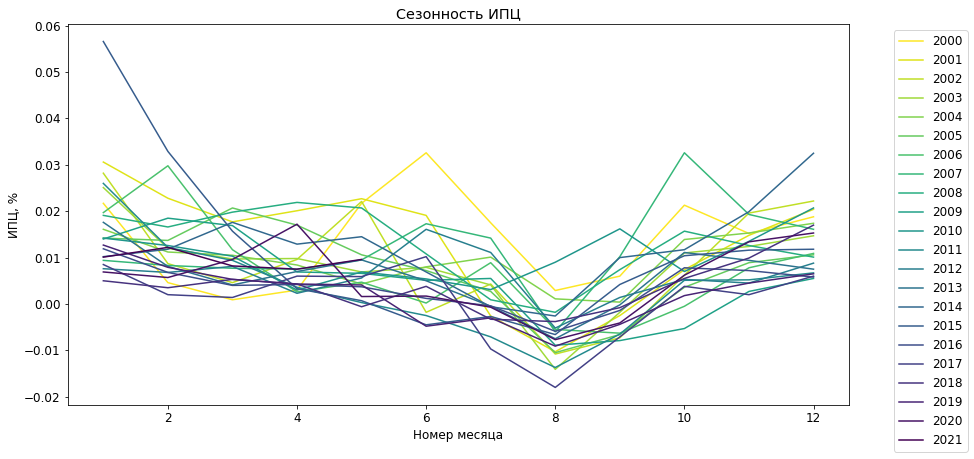

In [54]:
seasonal_plot(ts=data.foods['2000':], plot_size=(14, 7), n_periods=12,
              title='Сезонность ИПЦ', ylabel='ИПЦ, %', xlabel='Номер месяца')

И наконец, нам было бы интересно посмотреть на сравнительную динамику цен по разным годам. Вот, например, сейчас, в середине 2021 года, инфляция действительно высокая по сравнению с последней пятилеткой?

In [55]:
def range_plot(data, frequency, current_year,
              title, figsize, xlabel, ylabel,
              drop_year=None):
    '''
    frequency: "month", "quarter" 
    current_year - year to plot separately with line plot
    drop_year - year(s) not do display in variable range
    '''
    
    sns.set(style='whitegrid')   
        
    n_periods = getattr(data.index, frequency).unique().shape[0]
    low = data.groupby(getattr(data.index, frequency)).agg(np.min).values.reshape(n_periods)
    high = data.groupby(getattr(data.index, frequency)).agg(np.max).values.reshape(n_periods)
    
    if drop_year:
        if isinstance(drop_year, list):
            first, last = drop_year[0], drop_year[1]
        elif isinstance(drop_year, tuple):
            first, last = drop_year
        else:
            first = drop_year
            last = first
        
        data2 = data.drop(
            index=data[str(first):str(last)].index.values.squeeze())
    
        low = data2.groupby(getattr(data2.index, frequency)).agg(np.min).values.reshape(n_periods)
        high = data2.groupby(getattr(data2.index, frequency)).agg(np.max).values.reshape(n_periods)
        
    
    fig, ax = plt.subplots(figsize=figsize)
    ax.fill_between(x=getattr(data.index, frequency).unique().values, 
                     y1=high, y2=low, color='lightgray', alpha=0.8)
    
    ax.plot(getattr(data[str(current_year)].index, frequency),
             data[str(current_year)].values,
             color='blue', label=str(current_year))
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.legend()
    

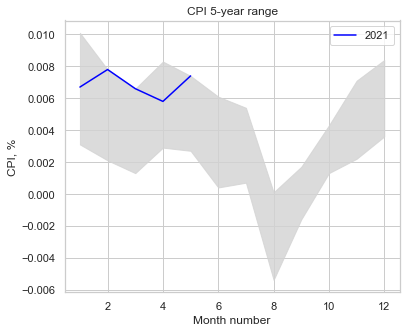

In [56]:
range_plot((data.cpi['2016':]), 'month', 2021,
          'CPI 5-year range', (6, 5),'Month number', 'CPI, %')

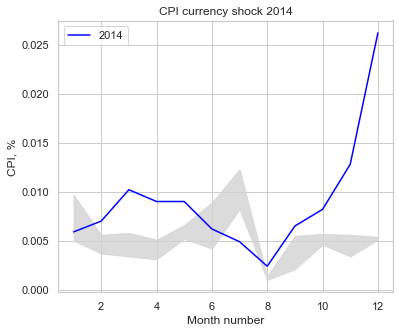

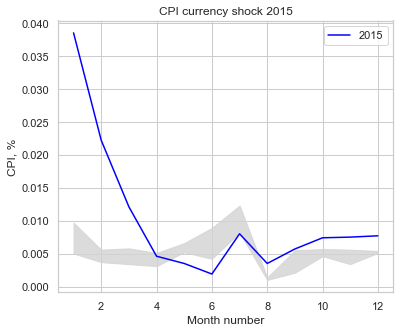

In [58]:
range_plot(data.cpi['2012':'2015'], 'month', 2014,
          'CPI currency shock 2014', (6, 5),'Month number', 'CPI, %',
          drop_year = [2014, 2015])

range_plot(data.cpi['2012':'2015'], 'month', 2015,
          'CPI currency shock 2015', (6, 5),'Month number', 'CPI, %',
          drop_year = [2014, 2015])

### 2. Модель для индекса ИПЦ в целом.  <a class="anchor" id="CPI"></a>

C:\Users\Vladimir\anaconda3\envs\portfolio\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


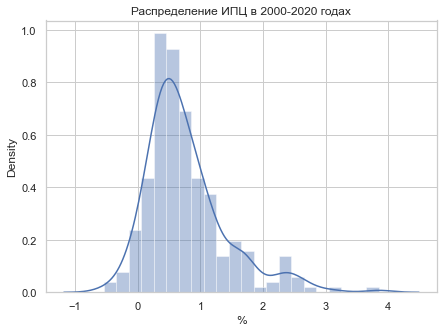

In [41]:
sns.set(style='whitegrid');
plt.figure(figsize=(7, 5))
plt.title('Распределение ИПЦ в 2000-2020 годах');
sns.distplot(data['2000':]-100);
plt.xlabel('%');

Посмотрим на выбросы.

In [155]:
(data['2000':]-100)[(data['2000':].cpi-100)>=2.5]

,cpi
2000-06-30,2.55
2001-01-31,2.76
2002-01-31,3.09
2005-01-31,2.62
2014-12-31,2.62
2015-01-31,3.85


In [156]:
from scipy import stats
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.api import qqplot

In [182]:
result = sm.tsa.stattools.adfuller(data.dropna().cpi.values.squeeze(),
                                  regression='c')
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -5.256625
p-value: 0.000007
Critical Values:
	1%: -3.450
	5%: -2.870
	10%: -2.571


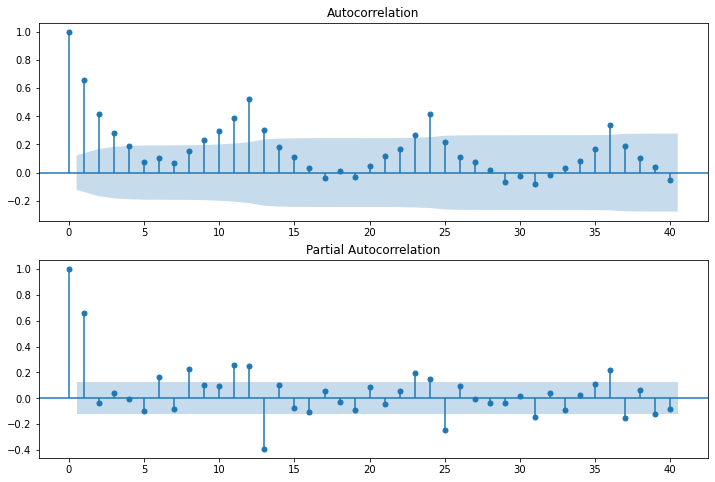

In [178]:
fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf((data['2000':]-100).dropna(), 
                                    lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf((data['2000':]-100).dropna(), 
                                    lags=40, ax=ax2)

* Судя по коррелограмме, можно рассмотреть модели SARIMAX(1,0,0)(1,0,1), SARIMAX(1,0,0)(2,0,2), SARIMAX(1,0,1)(1,0,1). Можно рассматривать данные после 2002 года, нужно добавить дамми на 2014 и 2015 годы (шок). 
* Ряд стационарный, гипотеза ADF-теста с дрифтом.
* Преобразование Бокса-Кокса не нужно, поскольку примерно в 2012 году дисперсия резко меняется и с той поры остаётся стабильной (смена экономической модели?).

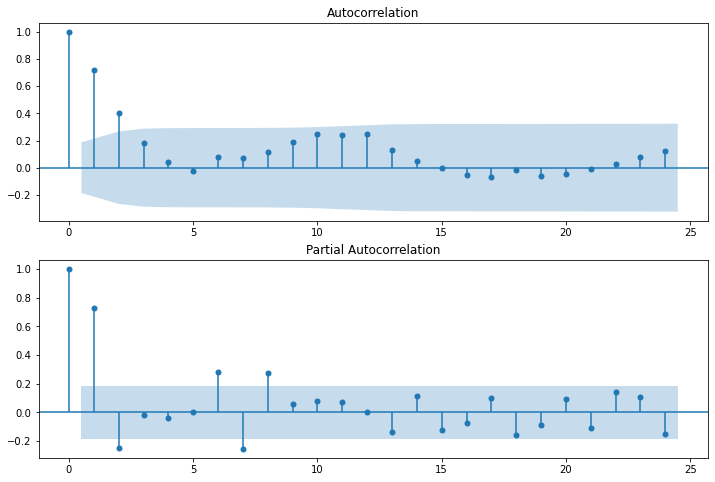

In [186]:
fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf((data['2012':]-100).dropna(), 
                                    lags=24, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf((data['2012':]-100).dropna(), 
                                    lags=24, ax=ax2)

In [187]:
train = data['2000':'2018']-100

In [262]:
sarimax1 = ARIMA(train.cpi, 
                 order=(1,0,0),
                 seasonal_order=(1,0,1, 12), 
                 trend='c')
res1 = sarimax1.fit()
print(res1.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                cpi   No. Observations:                  228
Model:             ARIMA(1, 0, 0)x(1, 0, [1], 12)   Log Likelihood                 -96.950
Date:                            Fri, 02 Apr 2021   AIC                            203.900
Time:                                    01:12:45   BIC                            221.047
Sample:                                01-31-2000   HQIC                           210.818
                                     - 12-31-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.8452      0.289      2.923      0.003       0.278       1.412
ar.L1          0.7127      0.040   

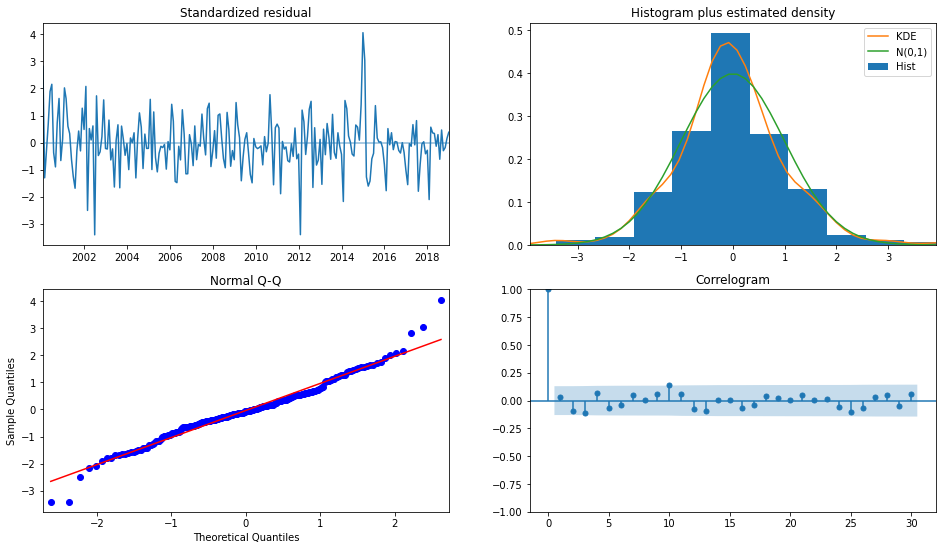

In [236]:
fig = plt.figure(figsize=(16,9))
fig = res1.plot_diagnostics(fig=fig, lags=30)

Дамми-переменная для шока.

In [250]:
data['shock']=0
data=data.astype({'shock':'float64'})
data['2014-11'].shock=0.25
data['2014-12'].shock=0.5
data['2015-01'].shock=1.0
data['2015-02'].shock=0.5
data['2015-03'].shock=0.25
data['2014-11':'2015-03']

C:\Users\Vladimir\anaconda3\envs\portfolio\lib\site-packages\pandas\core\generic.py:5170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


,cpi,shock
2014-11-30,101.28,0.25
2014-12-31,102.62,0.50
2015-01-31,103.85,1.00
2015-02-28,102.22,0.50
2015-03-31,101.21,0.25


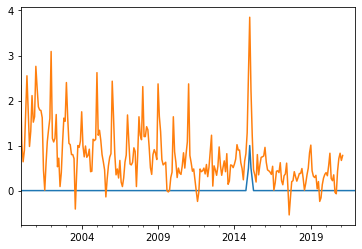

In [255]:
data['2000':].shock.plot();
(data['2000':].cpi-100).plot();

In [311]:
train = data['2000':'2018']
train.cpi-=100

In [312]:
train.head()

,cpi,shock
2000-01-31,2.33,0.0
2000-02-29,1.04,0.0
2000-03-31,0.64,0.0
2000-04-30,0.89,0.0
2000-05-31,1.75,0.0


In [313]:
mod_dummy = ARIMA(endog=train.cpi, 
                  exog=train.shock,
                  order=(1,0,0),
                  seasonal_order=(1,0,1, 12), 
                  trend='c') #'n' if no constant mean assumed
res2 = mod_dummy.fit()
print(res2.summary())

C:\Users\Vladimir\anaconda3\envs\portfolio\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


                                     SARIMAX Results                                      
Dep. Variable:                                cpi   No. Observations:                  228
Model:             ARIMA(1, 0, 0)x(1, 0, [1], 12)   Log Likelihood                 -73.965
Date:                            Fri, 02 Apr 2021   AIC                            159.930
Time:                                    01:35:31   BIC                            180.506
Sample:                                01-31-2000   HQIC                           168.232
                                     - 12-31-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.8312      0.229      3.622      0.000       0.381       1.281
shock          2.7743      0.331   

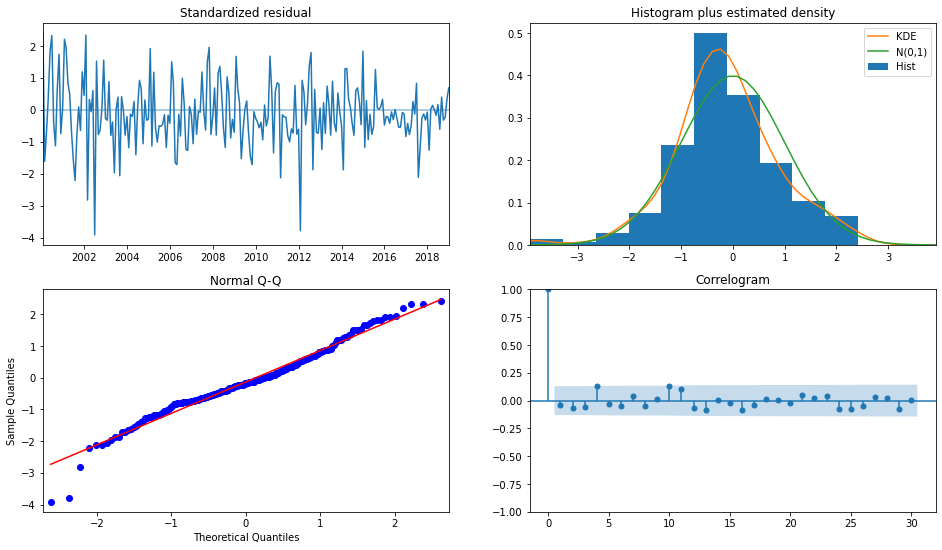

In [314]:
fig = plt.figure(figsize=(16,9))
fig = res2.plot_diagnostics(fig=fig, lags=30)

Отдельный вопрос - стоит ли добавлять в модель константу. На качество она особо не влияет. Возможно, стоит всё-таки подумать над преобразованием Бокса-Кокса в связи со сменой экономической модели - об этом наглядно говорят остатки.

**В 2019-2021 годах в какой-то момент при преобразованиях добавилось лишнее 100 - быть аккуратным, вычистить.**

Видно, что модель с дамми-переменной явно лучше.

### 3. Модель для трёх субиндексов ИПЦ: <a class="anchor" id="3indexes"></a>

### 3.1 Модель для продовольственных товаров. <a class="anchor" id="foods"></a>

### 3.2 Модель для непродовольственных товаров. <a class="anchor" id="nonfoods"></a>

### 3.3 Модель для цен на услуги. <a class="anchor" id="services"></a>

### 4. Агрегированная модель. <a class="anchor" id="aggmodel"></a>